# Instructions for Manual Simulation

1. Decide on a name for your model.  Add first letter of your name and numbers as prefix  For example: `t0_dummy`.
2. Create a `.py` file with the name of your model in the `trade_models` directory (`./trade_models/t0_dummy.py`)
3. Import your model in `./trade_models/__init__.py` by adding `from . import t0_dummy`
4. Place any pre-trained models or scalers into the `./trade_models/assets/` directory with your model name as prefix.
5. Configure portfolio in the following cells.
    1. For `max_batch_size`, it is purely for memory considerations.  It does an SQL query per batch, so don't make it too small.
    2. Parameters inside portfolios are accessible inside the trade models
6. Run all

Sample portfolio (all fields must exist)
```
    {
        'portfolio_name' : f'BTC <-> ETH dummy',
        'trade_model' : 't0_dummy',
        'starting_coin' : 'BTC',
        'pair_coin' : 'ETH',
        'max_batch_size' : 10000,
        'starting_funds' : 1,
        'trading_fees_percent' : 0.1, # trading fees in percent
    }
```

In [1]:
start_simulation = '2018-01-01' #YYYY-MM-DD
end_simulation = '2021-12-31' #YYYY-MM-DD

portfolios = [
    {
        # Common parameters
        'portfolio_name' : f'BTC <-> ETH t0_dummy no fees',
        'trade_model' : 't0_dummy',
        'starting_coin' : 'BTC',
        'pair_coin' : 'ETH',
        'max_batch_size' : 10000,
        'starting_funds' : 1,
        'trading_fees_percent' : 0.0, # trading fees in percent

        # Model specific parameteres
        'parameter_sample' : 'test',
    },
    {
        # Common parameters
        'portfolio_name' : f'ETH <-> BTC t0_dummy no fees',
        'trade_model' : 't0_dummy',
        'starting_coin' : 'ETH',
        'pair_coin' : 'BTC',
        'max_batch_size' : 10000,
        'starting_funds' : 1,
        'trading_fees_percent' : 0.0, # trading fees in percent

        # Model specific parameteres
        'parameter_sample' : 'test',
    },
    {
        # Common parameters
        'portfolio_name' : f'BTC <-> ETH t0_dummy 0.1% fees',
        'trade_model' : 't0_dummy',
        'starting_coin' : 'BTC',
        'pair_coin' : 'ETH',
        'max_batch_size' : 10000,
        'starting_funds' : 1,
        'trading_fees_percent' : 0.1, # trading fees in percent

        # Model specific parameteres
        'parameter_sample' : 'test',
    },
    {
        # Common parameters
        'portfolio_name' : f'ETH <-> BTC t0_dummy 0.1% fees',
        'trade_model' : 't0_dummy',
        'starting_coin' : 'ETH',
        'pair_coin' : 'BTC',
        'max_batch_size' : 10000,
        'starting_funds' : 1,
        'trading_fees_percent' : 0.1, # trading fees in percent

        # Model specific parameteres
        'parameter_sample' : 'test',
    },
#     {
#         # Common parameters
#         'portfolio_name' : f'BTC <-> USDT t0_dummy',
#         'trade_model' : 't0_dummy',
#         'starting_coin' : 'BTC',
#         'pair_coin' : 'USDT',
#         'max_batch_size' : 10000,
#         'starting_funds' : 1,
#         'trading_fees_percent' : 0.1, # trading fees in percent

#         # Model specific parameteres
#         'parameter_sample' : 'test',
#     },
#     {
#         # Common parameters
#         'portfolio_name' : f'USDT <-> BTC t0_dummy',
#         'trade_model' : 't0_dummy',
#         'starting_coin' : 'USDT',
#         'pair_coin' : 'BTC',
#         'max_batch_size' : 10000,
#         'starting_funds' : 1,
#         'trading_fees_percent' : 0.1, # trading fees in percent

#         # Model specific parameteres
#         'parameter_sample' : 'test',
#     },
#     {
#         # Common parameters
#         'portfolio_name' : f'USDT <-> ETH t0_dummy',
#         'trade_model' : 't0_dummy',
#         'starting_coin' : 'USDT',
#         'pair_coin' : 'ETH',
#         'max_batch_size' : 10000,
#         'starting_funds' : 1,
#         'trading_fees_percent' : 0.1, # trading fees in percent

#         # Model specific parameteres
#         'parameter_sample' : 'test',
#     },
#     {
#         # Common parameters
#         'portfolio_name' : f'ETH <-> USDT t0_dummy',
#         'trade_model' : 't0_dummy',
#         'starting_coin' : 'ETH',
#         'pair_coin' : 'USDT',
#         'max_batch_size' : 10000,
#         'starting_funds' : 1,
#         'trading_fees_percent' : 0.1, # trading fees in percent

#         # Model specific parameteres
#         'parameter_sample' : 'test',
#     },
]

# STOP

You shouldn't need to modify anything below this cell

# CODE FOR SIMULATION STARTS

In [2]:
import psycopg2
import pandas as pd
import numpy as np
import re

# models
import trade_models

In [3]:
# local postgres connection only
import hidden
sql_string = hidden.psycopg2(hidden.secrets())
print('PostgreSQL connection data taken from hidden.py')

# Make the connection and cursor
conn = psycopg2.connect(sql_string, connect_timeout=3)

PostgreSQL connection data taken from hidden.py


In [4]:
# validate inputs and portfolio parameters

import datetime
def validate(date_text):
    try:
        datetime.datetime.strptime(date_text, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")
        
# validate start / end string format input to protect against injection
validate(start_simulation)
validate(end_simulation)

for p in portfolios:
    # validate symbol
    assert re.match('^[A-Z]{2,}$', p['starting_coin']), f"{p['starting_coin']} is invalid starting coin"
    assert re.match('^[A-Z]{2,}$', p['pair_coin']), f"{p['pair_coin']} is invalid pair coin"

    # validate starting funds
    assert p['starting_funds'] > 0, "Starting funds for must be > 0"

    # validate fees
    assert p['trading_fees_percent'] >= 0, "Starting funds for must be >= 0%"
    assert p['trading_fees_percent'] < 100, "Starting funds for must be < 100%"

    # validate batch size
    assert (isinstance(p['max_batch_size'], int) and p['max_batch_size'] > 0), f"{p['max_batch_size']} is not a valid batch size"

    # maybe we should validate model names too!
    # TODO: validate model names

In [5]:
def get_pair_data(base_coin, other_coin):
    sql = f"""
    select
        p.*
    from pairs p
    where
        (p.coin1 = '{base_coin}' and p.coin2 = '{other_coin}')
    """
    df = pd.read_sql_query(sql, conn)
    if len(df) == 0:
        return None
    else:
        return df.iloc[0]

In [6]:
def get_batch_data(pair_id, start_time, end_time, batch_size):
    sql = f"""select * from (select
    *,
    LAG(open,1) over (order by open_time) open_1,LAG(open,2) over (order by open_time) open_2,LAG(open,3) over (order by open_time) open_3,LAG(open,4) over (order by open_time) open_4,LAG(open,5) over (order by open_time) open_5,LAG(open,6) over (order by open_time) open_6,LAG(open,7) over (order by open_time) open_7,LAG(open,8) over (order by open_time) open_8,LAG(open,9) over (order by open_time) open_9,LAG(open,10) over (order by open_time) open_10,LAG(open,11) over (order by open_time) open_11,LAG(open,12) over (order by open_time) open_12,LAG(open,13) over (order by open_time) open_13,LAG(open,14) over (order by open_time) open_14,LAG(high,1) over (order by open_time) high_1,LAG(high,2) over (order by open_time) high_2,LAG(high,3) over (order by open_time) high_3,LAG(high,4) over (order by open_time) high_4,LAG(high,5) over (order by open_time) high_5,LAG(high,6) over (order by open_time) high_6,LAG(high,7) over (order by open_time) high_7,LAG(high,8) over (order by open_time) high_8,LAG(high,9) over (order by open_time) high_9,LAG(high,10) over (order by open_time) high_10,LAG(high,11) over (order by open_time) high_11,LAG(high,12) over (order by open_time) high_12,LAG(high,13) over (order by open_time) high_13,LAG(high,14) over (order by open_time) high_14,LAG(low,1) over (order by open_time) low_1,LAG(low,2) over (order by open_time) low_2,LAG(low,3) over (order by open_time) low_3,LAG(low,4) over (order by open_time) low_4,LAG(low,5) over (order by open_time) low_5,LAG(low,6) over (order by open_time) low_6,LAG(low,7) over (order by open_time) low_7,LAG(low,8) over (order by open_time) low_8,LAG(low,9) over (order by open_time) low_9,LAG(low,10) over (order by open_time) low_10,LAG(low,11) over (order by open_time) low_11,LAG(low,12) over (order by open_time) low_12,LAG(low,13) over (order by open_time) low_13,LAG(low,14) over (order by open_time) low_14,LAG(close,1) over (order by open_time) close_1,LAG(close,2) over (order by open_time) close_2,LAG(close,3) over (order by open_time) close_3,LAG(close,4) over (order by open_time) close_4,LAG(close,5) over (order by open_time) close_5,LAG(close,6) over (order by open_time) close_6,LAG(close,7) over (order by open_time) close_7,LAG(close,8) over (order by open_time) close_8,LAG(close,9) over (order by open_time) close_9,LAG(close,10) over (order by open_time) close_10,LAG(close,11) over (order by open_time) close_11,LAG(close,12) over (order by open_time) close_12,LAG(close,13) over (order by open_time) close_13,LAG(close,14) over (order by open_time) close_14,LAG(ma14,1) over (order by open_time) ma14_1,LAG(ma14,2) over (order by open_time) ma14_2,LAG(ma14,3) over (order by open_time) ma14_3,LAG(ma14,4) over (order by open_time) ma14_4,LAG(ma14,5) over (order by open_time) ma14_5,LAG(ma14,6) over (order by open_time) ma14_6,LAG(ma14,7) over (order by open_time) ma14_7,LAG(ma14,8) over (order by open_time) ma14_8,LAG(ma14,9) over (order by open_time) ma14_9,LAG(ma14,10) over (order by open_time) ma14_10,LAG(ma14,11) over (order by open_time) ma14_11,LAG(ma14,12) over (order by open_time) ma14_12,LAG(ma14,13) over (order by open_time) ma14_13,LAG(ma14,14) over (order by open_time) ma14_14,LAG(ma30,1) over (order by open_time) ma30_1,LAG(ma30,2) over (order by open_time) ma30_2,LAG(ma30,3) over (order by open_time) ma30_3,LAG(ma30,4) over (order by open_time) ma30_4,LAG(ma30,5) over (order by open_time) ma30_5,LAG(ma30,6) over (order by open_time) ma30_6,LAG(ma30,7) over (order by open_time) ma30_7,LAG(ma30,8) over (order by open_time) ma30_8,LAG(ma30,9) over (order by open_time) ma30_9,LAG(ma30,10) over (order by open_time) ma30_10,LAG(ma30,11) over (order by open_time) ma30_11,LAG(ma30,12) over (order by open_time) ma30_12,LAG(ma30,13) over (order by open_time) ma30_13,LAG(ma30,14) over (order by open_time) ma30_14,LAG(ma90,1) over (order by open_time) ma90_1,LAG(ma90,2) over (order by open_time) ma90_2,LAG(ma90,3) over (order by open_time) ma90_3,LAG(ma90,4) over (order by open_time) ma90_4,LAG(ma90,5) over (order by open_time) ma90_5,LAG(ma90,6) over (order by open_time) ma90_6,LAG(ma90,7) over (order by open_time) ma90_7,LAG(ma90,8) over (order by open_time) ma90_8,LAG(ma90,9) over (order by open_time) ma90_9,LAG(ma90,10) over (order by open_time) ma90_10,LAG(ma90,11) over (order by open_time) ma90_11,LAG(ma90,12) over (order by open_time) ma90_12,LAG(ma90,13) over (order by open_time) ma90_13,LAG(ma90,14) over (order by open_time) ma90_14,LAG(atr,1) over (order by open_time) atr_1,LAG(atr,2) over (order by open_time) atr_2,LAG(atr,3) over (order by open_time) atr_3,LAG(atr,4) over (order by open_time) atr_4,LAG(atr,5) over (order by open_time) atr_5,LAG(atr,6) over (order by open_time) atr_6,LAG(atr,7) over (order by open_time) atr_7,LAG(atr,8) over (order by open_time) atr_8,LAG(atr,9) over (order by open_time) atr_9,LAG(atr,10) over (order by open_time) atr_10,LAG(atr,11) over (order by open_time) atr_11,LAG(atr,12) over (order by open_time) atr_12,LAG(atr,13) over (order by open_time) atr_13,LAG(atr,14) over (order by open_time) atr_14,LAG(atr_diff,1) over (order by open_time) atr_diff_1,LAG(atr_diff,2) over (order by open_time) atr_diff_2,LAG(atr_diff,3) over (order by open_time) atr_diff_3,LAG(atr_diff,4) over (order by open_time) atr_diff_4,LAG(atr_diff,5) over (order by open_time) atr_diff_5,LAG(atr_diff,6) over (order by open_time) atr_diff_6,LAG(atr_diff,7) over (order by open_time) atr_diff_7,LAG(atr_diff,8) over (order by open_time) atr_diff_8,LAG(atr_diff,9) over (order by open_time) atr_diff_9,LAG(atr_diff,10) over (order by open_time) atr_diff_10,LAG(atr_diff,11) over (order by open_time) atr_diff_11,LAG(atr_diff,12) over (order by open_time) atr_diff_12,LAG(atr_diff,13) over (order by open_time) atr_diff_13,LAG(atr_diff,14) over (order by open_time) atr_diff_14,LAG(atr_ma14,1) over (order by open_time) atr_ma14_1,LAG(atr_ma14,2) over (order by open_time) atr_ma14_2,LAG(atr_ma14,3) over (order by open_time) atr_ma14_3,LAG(atr_ma14,4) over (order by open_time) atr_ma14_4,LAG(atr_ma14,5) over (order by open_time) atr_ma14_5,LAG(atr_ma14,6) over (order by open_time) atr_ma14_6,LAG(atr_ma14,7) over (order by open_time) atr_ma14_7,LAG(atr_ma14,8) over (order by open_time) atr_ma14_8,LAG(atr_ma14,9) over (order by open_time) atr_ma14_9,LAG(atr_ma14,10) over (order by open_time) atr_ma14_10,LAG(atr_ma14,11) over (order by open_time) atr_ma14_11,LAG(atr_ma14,12) over (order by open_time) atr_ma14_12,LAG(atr_ma14,13) over (order by open_time) atr_ma14_13,LAG(atr_ma14,14) over (order by open_time) atr_ma14_14,LAG(rsi,1) over (order by open_time) rsi_1,LAG(rsi,2) over (order by open_time) rsi_2,LAG(rsi,3) over (order by open_time) rsi_3,LAG(rsi,4) over (order by open_time) rsi_4,LAG(rsi,5) over (order by open_time) rsi_5,LAG(rsi,6) over (order by open_time) rsi_6,LAG(rsi,7) over (order by open_time) rsi_7,LAG(rsi,8) over (order by open_time) rsi_8,LAG(rsi,9) over (order by open_time) rsi_9,LAG(rsi,10) over (order by open_time) rsi_10,LAG(rsi,11) over (order by open_time) rsi_11,LAG(rsi,12) over (order by open_time) rsi_12,LAG(rsi,13) over (order by open_time) rsi_13,LAG(rsi,14) over (order by open_time) rsi_14,LAG(rsi_diff,1) over (order by open_time) rsi_diff_1,LAG(rsi_diff,2) over (order by open_time) rsi_diff_2,LAG(rsi_diff,3) over (order by open_time) rsi_diff_3,LAG(rsi_diff,4) over (order by open_time) rsi_diff_4,LAG(rsi_diff,5) over (order by open_time) rsi_diff_5,LAG(rsi_diff,6) over (order by open_time) rsi_diff_6,LAG(rsi_diff,7) over (order by open_time) rsi_diff_7,LAG(rsi_diff,8) over (order by open_time) rsi_diff_8,LAG(rsi_diff,9) over (order by open_time) rsi_diff_9,LAG(rsi_diff,10) over (order by open_time) rsi_diff_10,LAG(rsi_diff,11) over (order by open_time) rsi_diff_11,LAG(rsi_diff,12) over (order by open_time) rsi_diff_12,LAG(rsi_diff,13) over (order by open_time) rsi_diff_13,LAG(rsi_diff,14) over (order by open_time) rsi_diff_14,LAG(rsi_ma14,1) over (order by open_time) rsi_ma14_1,LAG(rsi_ma14,2) over (order by open_time) rsi_ma14_2,LAG(rsi_ma14,3) over (order by open_time) rsi_ma14_3,LAG(rsi_ma14,4) over (order by open_time) rsi_ma14_4,LAG(rsi_ma14,5) over (order by open_time) rsi_ma14_5,LAG(rsi_ma14,6) over (order by open_time) rsi_ma14_6,LAG(rsi_ma14,7) over (order by open_time) rsi_ma14_7,LAG(rsi_ma14,8) over (order by open_time) rsi_ma14_8,LAG(rsi_ma14,9) over (order by open_time) rsi_ma14_9,LAG(rsi_ma14,10) over (order by open_time) rsi_ma14_10,LAG(rsi_ma14,11) over (order by open_time) rsi_ma14_11,LAG(rsi_ma14,12) over (order by open_time) rsi_ma14_12,LAG(rsi_ma14,13) over (order by open_time) rsi_ma14_13,LAG(rsi_ma14,14) over (order by open_time) rsi_ma14_14,LAG(trend_up,1) over (order by open_time) trend_up_1,LAG(trend_up,2) over (order by open_time) trend_up_2,LAG(trend_up,3) over (order by open_time) trend_up_3,LAG(trend_up,4) over (order by open_time) trend_up_4,LAG(trend_up,5) over (order by open_time) trend_up_5,LAG(trend_up,6) over (order by open_time) trend_up_6,LAG(trend_up,7) over (order by open_time) trend_up_7,LAG(trend_up,8) over (order by open_time) trend_up_8,LAG(trend_up,9) over (order by open_time) trend_up_9,LAG(trend_up,10) over (order by open_time) trend_up_10,LAG(trend_up,11) over (order by open_time) trend_up_11,LAG(trend_up,12) over (order by open_time) trend_up_12,LAG(trend_up,13) over (order by open_time) trend_up_13,LAG(trend_up,14) over (order by open_time) trend_up_14,LAG(trend_up3,1) over (order by open_time) trend_up3_1,LAG(trend_up3,2) over (order by open_time) trend_up3_2,LAG(trend_up3,3) over (order by open_time) trend_up3_3,LAG(trend_up3,4) over (order by open_time) trend_up3_4,LAG(trend_up3,5) over (order by open_time) trend_up3_5,LAG(trend_up3,6) over (order by open_time) trend_up3_6,LAG(trend_up3,7) over (order by open_time) trend_up3_7,LAG(trend_up3,8) over (order by open_time) trend_up3_8,LAG(trend_up3,9) over (order by open_time) trend_up3_9,LAG(trend_up3,10) over (order by open_time) trend_up3_10,LAG(trend_up3,11) over (order by open_time) trend_up3_11,LAG(trend_up3,12) over (order by open_time) trend_up3_12,LAG(trend_up3,13) over (order by open_time) trend_up3_13,LAG(trend_up3,14) over (order by open_time) trend_up3_14,LAG(trend_up14,1) over (order by open_time) trend_up14_1,LAG(trend_up14,2) over (order by open_time) trend_up14_2,LAG(trend_up14,3) over (order by open_time) trend_up14_3,LAG(trend_up14,4) over (order by open_time) trend_up14_4,LAG(trend_up14,5) over (order by open_time) trend_up14_5,LAG(trend_up14,6) over (order by open_time) trend_up14_6,LAG(trend_up14,7) over (order by open_time) trend_up14_7,LAG(trend_up14,8) over (order by open_time) trend_up14_8,LAG(trend_up14,9) over (order by open_time) trend_up14_9,LAG(trend_up14,10) over (order by open_time) trend_up14_10,LAG(trend_up14,11) over (order by open_time) trend_up14_11,LAG(trend_up14,12) over (order by open_time) trend_up14_12,LAG(trend_up14,13) over (order by open_time) trend_up14_13,LAG(trend_up14,14) over (order by open_time) trend_up14_14,LAG(trend_up30,1) over (order by open_time) trend_up30_1,LAG(trend_up30,2) over (order by open_time) trend_up30_2,LAG(trend_up30,3) over (order by open_time) trend_up30_3,LAG(trend_up30,4) over (order by open_time) trend_up30_4,LAG(trend_up30,5) over (order by open_time) trend_up30_5,LAG(trend_up30,6) over (order by open_time) trend_up30_6,LAG(trend_up30,7) over (order by open_time) trend_up30_7,LAG(trend_up30,8) over (order by open_time) trend_up30_8,LAG(trend_up30,9) over (order by open_time) trend_up30_9,LAG(trend_up30,10) over (order by open_time) trend_up30_10,LAG(trend_up30,11) over (order by open_time) trend_up30_11,LAG(trend_up30,12) over (order by open_time) trend_up30_12,LAG(trend_up30,13) over (order by open_time) trend_up30_13,LAG(trend_up30,14) over (order by open_time) trend_up30_14,LAG(cs_ss,1) over (order by open_time) cs_ss_1,LAG(cs_ss,2) over (order by open_time) cs_ss_2,LAG(cs_ss,3) over (order by open_time) cs_ss_3,LAG(cs_ss,4) over (order by open_time) cs_ss_4,LAG(cs_ss,5) over (order by open_time) cs_ss_5,LAG(cs_ss,6) over (order by open_time) cs_ss_6,LAG(cs_ss,7) over (order by open_time) cs_ss_7,LAG(cs_ss,8) over (order by open_time) cs_ss_8,LAG(cs_ss,9) over (order by open_time) cs_ss_9,LAG(cs_ss,10) over (order by open_time) cs_ss_10,LAG(cs_ss,11) over (order by open_time) cs_ss_11,LAG(cs_ss,12) over (order by open_time) cs_ss_12,LAG(cs_ss,13) over (order by open_time) cs_ss_13,LAG(cs_ss,14) over (order by open_time) cs_ss_14,LAG(cs_ssr,1) over (order by open_time) cs_ssr_1,LAG(cs_ssr,2) over (order by open_time) cs_ssr_2,LAG(cs_ssr,3) over (order by open_time) cs_ssr_3,LAG(cs_ssr,4) over (order by open_time) cs_ssr_4,LAG(cs_ssr,5) over (order by open_time) cs_ssr_5,LAG(cs_ssr,6) over (order by open_time) cs_ssr_6,LAG(cs_ssr,7) over (order by open_time) cs_ssr_7,LAG(cs_ssr,8) over (order by open_time) cs_ssr_8,LAG(cs_ssr,9) over (order by open_time) cs_ssr_9,LAG(cs_ssr,10) over (order by open_time) cs_ssr_10,LAG(cs_ssr,11) over (order by open_time) cs_ssr_11,LAG(cs_ssr,12) over (order by open_time) cs_ssr_12,LAG(cs_ssr,13) over (order by open_time) cs_ssr_13,LAG(cs_ssr,14) over (order by open_time) cs_ssr_14,LAG(cs_hm,1) over (order by open_time) cs_hm_1,LAG(cs_hm,2) over (order by open_time) cs_hm_2,LAG(cs_hm,3) over (order by open_time) cs_hm_3,LAG(cs_hm,4) over (order by open_time) cs_hm_4,LAG(cs_hm,5) over (order by open_time) cs_hm_5,LAG(cs_hm,6) over (order by open_time) cs_hm_6,LAG(cs_hm,7) over (order by open_time) cs_hm_7,LAG(cs_hm,8) over (order by open_time) cs_hm_8,LAG(cs_hm,9) over (order by open_time) cs_hm_9,LAG(cs_hm,10) over (order by open_time) cs_hm_10,LAG(cs_hm,11) over (order by open_time) cs_hm_11,LAG(cs_hm,12) over (order by open_time) cs_hm_12,LAG(cs_hm,13) over (order by open_time) cs_hm_13,LAG(cs_hm,14) over (order by open_time) cs_hm_14,LAG(cs_hmr,1) over (order by open_time) cs_hmr_1,LAG(cs_hmr,2) over (order by open_time) cs_hmr_2,LAG(cs_hmr,3) over (order by open_time) cs_hmr_3,LAG(cs_hmr,4) over (order by open_time) cs_hmr_4,LAG(cs_hmr,5) over (order by open_time) cs_hmr_5,LAG(cs_hmr,6) over (order by open_time) cs_hmr_6,LAG(cs_hmr,7) over (order by open_time) cs_hmr_7,LAG(cs_hmr,8) over (order by open_time) cs_hmr_8,LAG(cs_hmr,9) over (order by open_time) cs_hmr_9,LAG(cs_hmr,10) over (order by open_time) cs_hmr_10,LAG(cs_hmr,11) over (order by open_time) cs_hmr_11,LAG(cs_hmr,12) over (order by open_time) cs_hmr_12,LAG(cs_hmr,13) over (order by open_time) cs_hmr_13,LAG(cs_hmr,14) over (order by open_time) cs_hmr_14,LAG(cs_brh,1) over (order by open_time) cs_brh_1,LAG(cs_brh,2) over (order by open_time) cs_brh_2,LAG(cs_brh,3) over (order by open_time) cs_brh_3,LAG(cs_brh,4) over (order by open_time) cs_brh_4,LAG(cs_brh,5) over (order by open_time) cs_brh_5,LAG(cs_brh,6) over (order by open_time) cs_brh_6,LAG(cs_brh,7) over (order by open_time) cs_brh_7,LAG(cs_brh,8) over (order by open_time) cs_brh_8,LAG(cs_brh,9) over (order by open_time) cs_brh_9,LAG(cs_brh,10) over (order by open_time) cs_brh_10,LAG(cs_brh,11) over (order by open_time) cs_brh_11,LAG(cs_brh,12) over (order by open_time) cs_brh_12,LAG(cs_brh,13) over (order by open_time) cs_brh_13,LAG(cs_brh,14) over (order by open_time) cs_brh_14,LAG(cs_buh,1) over (order by open_time) cs_buh_1,LAG(cs_buh,2) over (order by open_time) cs_buh_2,LAG(cs_buh,3) over (order by open_time) cs_buh_3,LAG(cs_buh,4) over (order by open_time) cs_buh_4,LAG(cs_buh,5) over (order by open_time) cs_buh_5,LAG(cs_buh,6) over (order by open_time) cs_buh_6,LAG(cs_buh,7) over (order by open_time) cs_buh_7,LAG(cs_buh,8) over (order by open_time) cs_buh_8,LAG(cs_buh,9) over (order by open_time) cs_buh_9,LAG(cs_buh,10) over (order by open_time) cs_buh_10,LAG(cs_buh,11) over (order by open_time) cs_buh_11,LAG(cs_buh,12) over (order by open_time) cs_buh_12,LAG(cs_buh,13) over (order by open_time) cs_buh_13,LAG(cs_buh,14) over (order by open_time) cs_buh_14,LAG(cs_ebu,1) over (order by open_time) cs_ebu_1,LAG(cs_ebu,2) over (order by open_time) cs_ebu_2,LAG(cs_ebu,3) over (order by open_time) cs_ebu_3,LAG(cs_ebu,4) over (order by open_time) cs_ebu_4,LAG(cs_ebu,5) over (order by open_time) cs_ebu_5,LAG(cs_ebu,6) over (order by open_time) cs_ebu_6,LAG(cs_ebu,7) over (order by open_time) cs_ebu_7,LAG(cs_ebu,8) over (order by open_time) cs_ebu_8,LAG(cs_ebu,9) over (order by open_time) cs_ebu_9,LAG(cs_ebu,10) over (order by open_time) cs_ebu_10,LAG(cs_ebu,11) over (order by open_time) cs_ebu_11,LAG(cs_ebu,12) over (order by open_time) cs_ebu_12,LAG(cs_ebu,13) over (order by open_time) cs_ebu_13,LAG(cs_ebu,14) over (order by open_time) cs_ebu_14,LAG(cs_ebr,1) over (order by open_time) cs_ebr_1,LAG(cs_ebr,2) over (order by open_time) cs_ebr_2,LAG(cs_ebr,3) over (order by open_time) cs_ebr_3,LAG(cs_ebr,4) over (order by open_time) cs_ebr_4,LAG(cs_ebr,5) over (order by open_time) cs_ebr_5,LAG(cs_ebr,6) over (order by open_time) cs_ebr_6,LAG(cs_ebr,7) over (order by open_time) cs_ebr_7,LAG(cs_ebr,8) over (order by open_time) cs_ebr_8,LAG(cs_ebr,9) over (order by open_time) cs_ebr_9,LAG(cs_ebr,10) over (order by open_time) cs_ebr_10,LAG(cs_ebr,11) over (order by open_time) cs_ebr_11,LAG(cs_ebr,12) over (order by open_time) cs_ebr_12,LAG(cs_ebr,13) over (order by open_time) cs_ebr_13,LAG(cs_ebr,14) over (order by open_time) cs_ebr_14
from
(select 
    cm.pair_id, cm.open_time, cm.close_time,
    f.dow, f.tod,
    cm.volume, cm.quote_asset_volume, cm.number_of_trades, cm.taker_buy_base_asset_volume, cm.taker_buy_quote_asset_volume,
    cm.open, cm.high, cm.low, cm.close,
    f.ma14, f.ma30, f.ma90,
    f.atr, f.atr_diff, f.atr_ma14,
    f.rsi, f.rsi_diff, f.rsi_ma14,
    f.trend_up, f.trend_up3, f.trend_up14, f.trend_up30,
    f.cs_ss, f.cs_ssr, f.cs_hm, f.cs_hmr, f.cs_brh, f.cs_buh, f.cs_ebu, f.cs_ebr
from
    ((select * from candlestick_15m where close_time notnull
            and pair_id = {pair_id}
            and open_time < '{start_time}'
        order by open_time desc limit 14)
    union all
        (select * from candlestick_15m where close_time notnull
            and pair_id = {pair_id}
            and open_time between '{start_time}' and '{end_time}'
        order by open_time limit {batch_size})) cm
inner join
    features f
on
    f.pair_id = cm.pair_id and f.candle_open_time = cm.open_time) data) final where open_time >= '{start_time}' order by open_time"""
    df = pd.read_sql_query(sql, conn)

    return df

In [7]:
def simulate_portfolio(start_time, end_time, portfolio):
    portfolio_name = portfolio['portfolio_name']
    trade_model = portfolio['trade_model']
    starting_coin = portfolio['starting_coin']
    pair_coin = portfolio['pair_coin']
    max_batch_size = portfolio['max_batch_size']
    starting_funds = portfolio['starting_funds']
    fee_multiplier = 1.0 - portfolio['trading_fees_percent'] / 100
    
    pair_data = get_pair_data(starting_coin, pair_coin)

    model = trade_models.__dict__[trade_model]
    columns = model.columns()

    current_time = start_time
    all_output = []
    
    info_dict = {'portfolio':portfolio}

    while True:
        # this batch data should also include feature engineering
        batch_data = get_batch_data(pair_data['id'], current_time, end_time, max_batch_size)
        print(current_time, len(batch_data))
        if len(batch_data) == 0:
            break

        batch_model_decision = model.make_decision(batch_data[columns], info_dict)

        output = batch_data[['open_time','open', 'high', 'low', 'close']].copy()
        output['trade_decision'] = batch_model_decision

        all_output.append(output)
        current_time = batch_data['close_time'].max()

    results = pd.concat(all_output).set_index('open_time')
    
    results[['fund1','fund2','action']] = np.nan
    cur_funds = [starting_funds,0]
    results.iloc[0, results.columns.get_loc('fund1')] = starting_funds
    results.iloc[0, results.columns.get_loc('fund2')] = 0

    for x,r in results.iterrows():
        if cur_funds[0] > 0:
            if r['trade_decision'] == 1:
                cur_funds[1] = (cur_funds[0] * r['close']) * fee_multiplier
                cur_funds[0] = 0
                results.loc[x,'fund1'] = cur_funds[0]
                results.loc[x,'fund2'] = cur_funds[1]
                results.loc[x,'action'] = 'buy'
        else:
            if r['trade_decision'] == -1:
                cur_funds[0] = (cur_funds[1] / r['open']) * fee_multiplier
                cur_funds[1] = 0
                results.loc[x,'fund1'] = cur_funds[0]
                results.loc[x,'fund2'] = cur_funds[1]
                results.loc[x,'action'] = 'sell'
    results[['fund1','fund2']] = results[['fund1','fund2']].ffill()
    results['total_value'] = results['fund1'] + results['fund2'] / results['close']
    results['action'] = results['action'].fillna('none')
    return portfolio_name, results

In [8]:
simulation_results = {}

for p in portfolios:
    print(f"Simulating \"{p['portfolio_name']}\"")
    name, res = simulate_portfolio(start_simulation, end_simulation, p)
    simulation_results[name] = res
    print(f"Final value: {res.iloc[-1,-1]}\n\n")

Simulating "BTC <-> ETH t0_dummy no fees"
2018-01-01 10000
2018-04-16 15:29:59.999000 10000
2018-07-30 04:44:59.999000 10000
2018-11-11 12:14:59.999000 10000
2019-02-23 23:14:59.999000 10000
2019-06-08 20:14:59.999000 10000
2019-09-21 08:14:59.999000 10000
2020-01-03 16:29:59.999000 10000
2020-04-17 05:14:59.999000 10000
2020-07-30 15:14:59.999000 10000
2020-11-11 19:14:59.999000 10000
2021-02-24 06:14:59.999000 10000
2021-06-08 18:44:59.999000 4682
2021-07-27 13:14:59 0
Final value: 1.4801725246993112


Simulating "ETH <-> BTC t0_dummy no fees"
2018-01-01 10000
2018-04-16 15:29:59.999000 10000
2018-07-30 04:44:59.999000 10000
2018-11-11 12:14:59.999000 10000
2019-02-23 23:14:59.999000 10000
2019-06-08 20:14:59.999000 10000
2019-09-21 08:14:59.999000 10000
2020-01-03 16:29:59.999000 10000
2020-04-17 05:14:59.999000 10000
2020-07-30 15:14:59.999000 10000
2020-11-11 19:14:59.999000 10000
2021-02-24 06:14:59.999000 10000
2021-06-08 18:44:59.999000 4673
2021-07-27 13:14:59 0
Final value: 0

# END SIMULATION

# THIS IS HOW YOU GET THE LATEST DATA FROM RDS

In [9]:
# %%time
# df = get_batch_data(pair_id=0, start_time='2018-01-01', end_time='2021-12-31', batch_size=1000000)

In [10]:
for k,v in simulation_results.items():
    print(k)
    print(f"Portfolio simulation for {p['starting_funds']} {p['starting_coin']} trading against {p['pair_coin']}")
    display(v[v['action']!='none'])
    display(v['action'].value_counts())

BTC <-> ETH t0_dummy no fees
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_decision,fund1,fund2,action,total_value
open_time,,,,,,,,,
2018-01-02 02:00:00,15.939049,16.363934,15.384852,15.646759,1,0.000000,15.646759,buy,1.000000
2018-01-02 08:00:00,15.762677,15.843090,15.739356,15.824538,-1,0.992646,0.000000,sell,0.992646
2018-01-03 02:00:00,17.149717,17.149717,17.008249,17.061935,1,0.000000,16.936462,buy,0.992646
2018-01-03 04:00:00,17.332224,17.414625,17.271157,17.323217,-1,0.977166,0.000000,sell,0.977166
2018-01-03 18:00:00,17.020697,17.021277,16.829350,16.865966,1,0.000000,16.480850,buy,0.977166
...,...,...,...,...,...,...,...,...,...
2021-07-18 02:45:00,16.249066,16.256726,16.205092,16.240621,-1,1.491452,0.000000,sell,1.491452
2021-07-22 12:45:00,16.146742,16.177303,16.000512,16.033349,1,0.000000,23.912969,buy,1.491452
2021-07-22 14:45:00,16.151436,16.158221,16.120972,16.143874,-1,1.480548,0.000000,sell,1.480548


none    123668
sell       507
buy        507
Name: action, dtype: int64

ETH <-> BTC t0_dummy no fees
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_decision,fund1,fund2,action,total_value
open_time,,,,,,,,,
2018-01-01 20:00:00,0.056420,0.056453,0.056011,0.056073,1,0.000000,0.056073,buy,1.000000
2018-01-01 22:00:00,0.056206,0.056288,0.056012,0.056049,-1,0.997634,0.000000,sell,0.997634
2018-01-02 10:00:00,0.062369,0.062463,0.062031,0.062033,1,0.000000,0.061886,buy,0.997634
2018-01-02 12:00:00,0.062917,0.063153,0.062561,0.062833,-1,0.983617,0.000000,sell,0.983617
2018-01-02 18:00:00,0.062994,0.063084,0.062100,0.062182,1,0.000000,0.061163,buy,0.983617
...,...,...,...,...,...,...,...,...,...
2021-07-20 03:00:00,0.057994,0.058154,0.057927,0.058065,-1,0.852859,0.000000,sell,0.852859
2021-07-26 01:00:00,0.061474,0.061550,0.058669,0.060378,1,0.000000,0.051494,buy,0.852859
2021-07-26 03:00:00,0.060508,0.060660,0.060395,0.060600,-1,0.851027,0.000000,sell,0.851027


none    123735
sell       469
buy        469
Name: action, dtype: int64

BTC <-> ETH t0_dummy 0.1% fees
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_decision,fund1,fund2,action,total_value
open_time,,,,,,,,,
2018-01-02 02:00:00,15.939049,16.363934,15.384852,15.646759,1,0.000000,15.631112,buy,0.999000
2018-01-02 08:00:00,15.762677,15.843090,15.739356,15.824538,-1,0.990662,0.000000,sell,0.990662
2018-01-03 02:00:00,17.149717,17.149717,17.008249,17.061935,1,0.000000,16.885703,buy,0.989671
2018-01-03 04:00:00,17.332224,17.414625,17.271157,17.323217,-1,0.973263,0.000000,sell,0.973263
2018-01-03 18:00:00,17.020697,17.021277,16.829350,16.865966,1,0.000000,16.398611,buy,0.972290
...,...,...,...,...,...,...,...,...,...
2021-07-18 02:45:00,16.249066,16.256726,16.205092,16.240621,-1,0.542941,0.000000,sell,0.542941
2021-07-22 12:45:00,16.146742,16.177303,16.000512,16.033349,1,0.000000,8.696452,buy,0.542398
2021-07-22 14:45:00,16.151436,16.158221,16.120972,16.143874,-1,0.537894,0.000000,sell,0.537894


none    123669
sell       507
buy        507
Name: action, dtype: int64

ETH <-> BTC t0_dummy 0.1% fees
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_decision,fund1,fund2,action,total_value
open_time,,,,,,,,,
2018-01-01 20:00:00,0.056420,0.056453,0.056011,0.056073,1,0.000000,0.056017,buy,0.999000
2018-01-01 22:00:00,0.056206,0.056288,0.056012,0.056049,-1,0.995639,0.000000,sell,0.995639
2018-01-02 10:00:00,0.062369,0.062463,0.062031,0.062033,1,0.000000,0.061701,buy,0.994644
2018-01-02 12:00:00,0.062917,0.063153,0.062561,0.062833,-1,0.979688,0.000000,sell,0.979688
2018-01-02 18:00:00,0.062994,0.063084,0.062100,0.062182,1,0.000000,0.060858,buy,0.978708
...,...,...,...,...,...,...,...,...,...
2021-07-20 03:00:00,0.057994,0.058154,0.057927,0.058065,-1,0.334999,0.000000,sell,0.334999
2021-07-26 01:00:00,0.061474,0.061550,0.058669,0.060378,1,0.000000,0.020206,buy,0.334664
2021-07-26 03:00:00,0.060508,0.060660,0.060395,0.060600,-1,0.333611,0.000000,sell,0.333611


none    123736
sell       469
buy        469
Name: action, dtype: int64

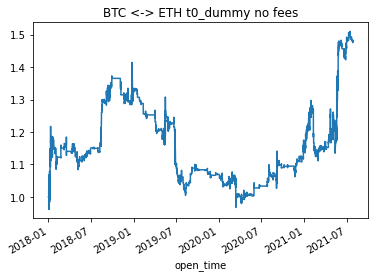

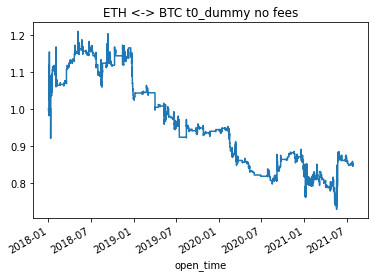

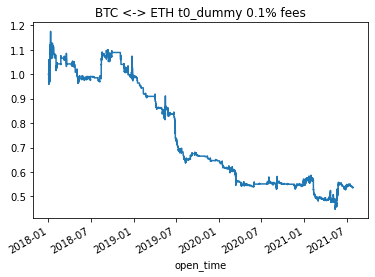

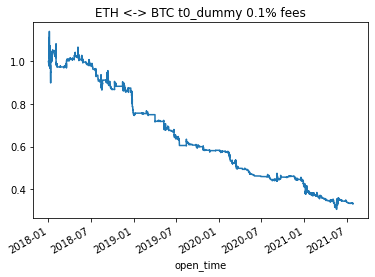

In [11]:
import matplotlib.pyplot as plt
for k,v in simulation_results.items():
    fig, ax = plt.subplots()
    ax.set_title(k)
    v.total_value.plot(figure=fig)